# Heart Failure Classification 
### Prédiction de la survie de patients atteints d'insuffisance cardiaque avec l'algorithme **K-Means**
---
* [Imports](#imports)
* [Présentation et analyse rapide du dataset](#data)
* [Réduction de dimensions avec PCA](#pca)
* [Recherche du nombre de clusters optimaux](#clusters)
    * [Silhouette Score & Calinksi-Harabasz score](#scores)
    * [Elbow Method](#elbow)
* [Entraînement et évaluation de modèles](#models)
    * [Modèle de base](#basic)
    * [Améliorations](#improvements)

## Imports <a class="anchor" id="imports"></a>
---

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score, adjusted_rand_score, normalized_mutual_info_score, ConfusionMatrixDisplay
from yellowbrick.cluster import KElbowVisualizer

## Présentation et analyse rapide du dataset <a id="data"></a>
---

Le dataset que nous avons choisi contient les données médicales de 299 patients ayant eu une insuffisance cardiaque collectées pendant leur période de suivi. Les données médicales sont divisés en 12 features :
- l'**âge** - INT
- la présence **d'anémie**, qui survient quand il n'y a pas assez d'hémoglobine dans le corps pour transporter l'oxygène vers les organes et tissus - BOOLEAN
- la quantité de **créatinine phosphokinase (CPK)** en mcg/L, une enzyme présente dans le corps - INT
- la présence de **diabète** - BOOLEAN
- la **fraction d'éjection**, ou le pourcentage de sang qui quitte le coeur à chaque contraction - INT
- la présence d'**hypertension** - BOOLEAN
- la quantité de **plaquettes** dans le sang en kiloplatelets/mL - FLOAT
- la quantité de **créatinine sérique** dans le sang en mg/dL - FLOAT
- la quantité de **sodium sérique** dans le sang en mEq/L - INT
- le **sexe** (0 pour femme, 1 pour homme) - BOOLEAN
- le fait que le patient soit **fumeur** - BOOLEAN
- le **temps**, soit la période de suivi du patient

Avec ces features, on souhaite prédire si le patient est décédé ou non pendant la période de suivi médical, qui est stocké dans la colonne **DEATH_EVENT** du dataset.

Voici le lien de notre dataset : https://www.kaggle.com/datasets/rabieelkharoua/predict-survival-of-patients-with-heart-failure

In [4]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
df.isna().values.any()

False

Comme nous pouvons le voir, il n'y a aucun pré-traitement à effectuer sur les valeurs des données, elles sont toutes numériques et aucune valeur n'est nulle.

Nous allons maintenant analyser les données de ce dataset.

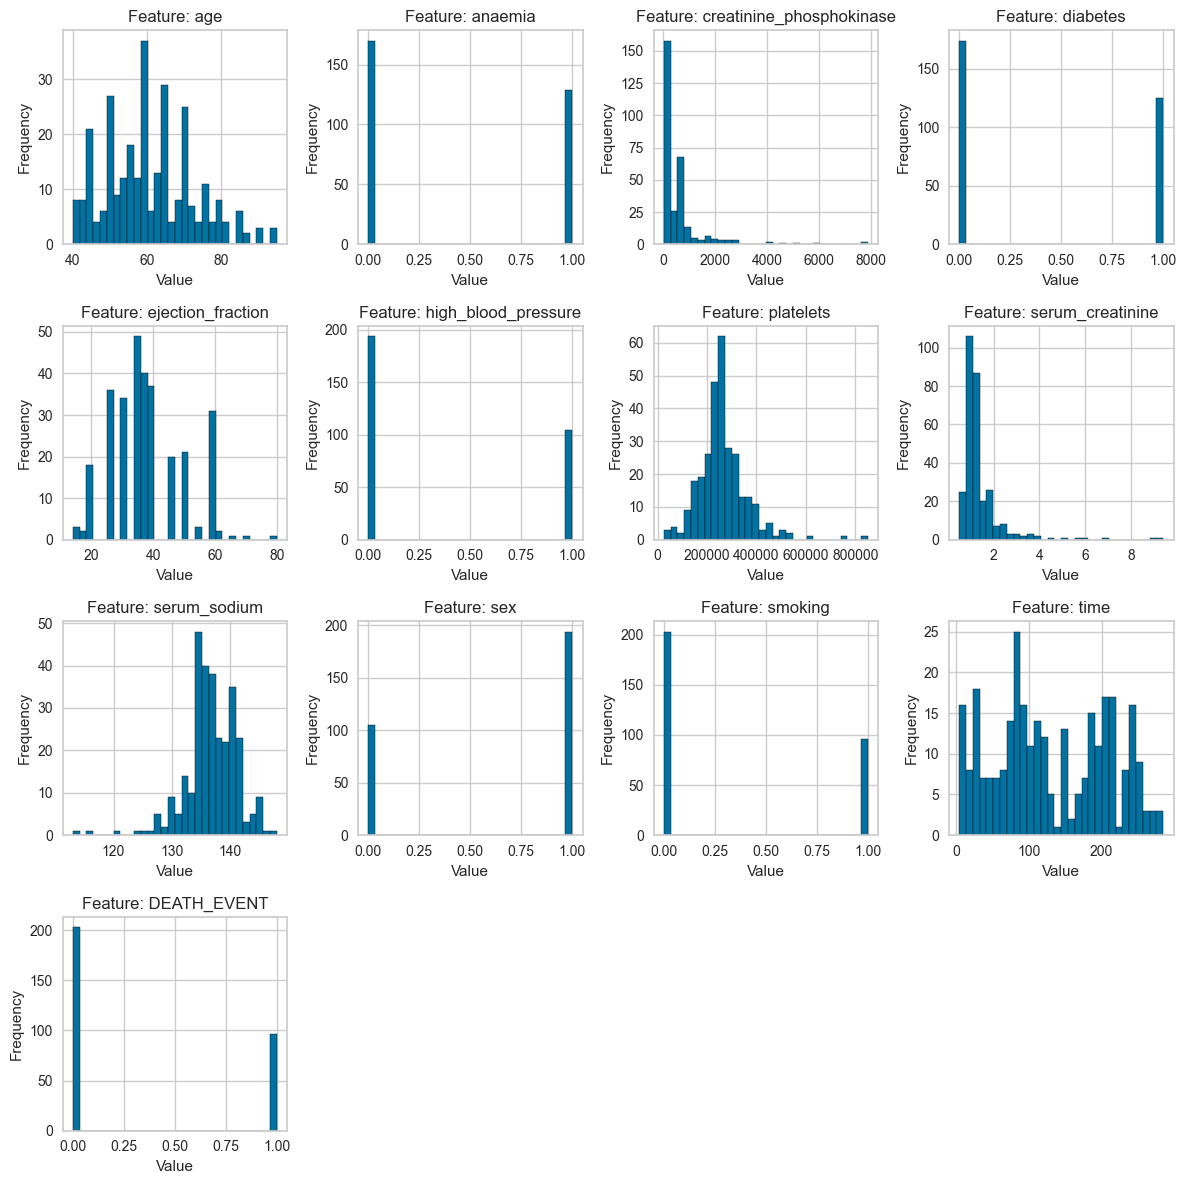

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

axes = axes.flatten()

for i, column in enumerate(df.columns):
    df[column].hist(ax=axes[i], bins=30, edgecolor='black')
    axes[i].set_title(f'Feature: {column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

for i in range(13, 16):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Nous remarquons que chaque feature est assez bien répartie donc il est difficile à première vue de voir lesquelles pourraient être utiles ou non pour **K-Means**.

In [7]:
alive_pourcentage = len(df[df["DEATH_EVENT"] == 0]) / len(df)
death_pourcentage = 1 - alive_pourcentage

print(f"alive pourcentage : {alive_pourcentage} ; death pourcentage : {death_pourcentage}")

alive pourcentage : 0.6789297658862876 ; death pourcentage : 0.3210702341137124


Cependant, le **y** de notre dataset, soit **DEATH_EVENT**, n'est pas très bien équilibré, mais cela n'a pas énormément d'importance car nous allons faire du clustering.

## Réduction de dimensions avec PCA <a id="pca"></a>
---  

In [8]:
X = df.drop(columns=["DEATH_EVENT"])
y = df["DEATH_EVENT"]

<Axes: title={'center': 'Pearson correlation of Medical Features'}>

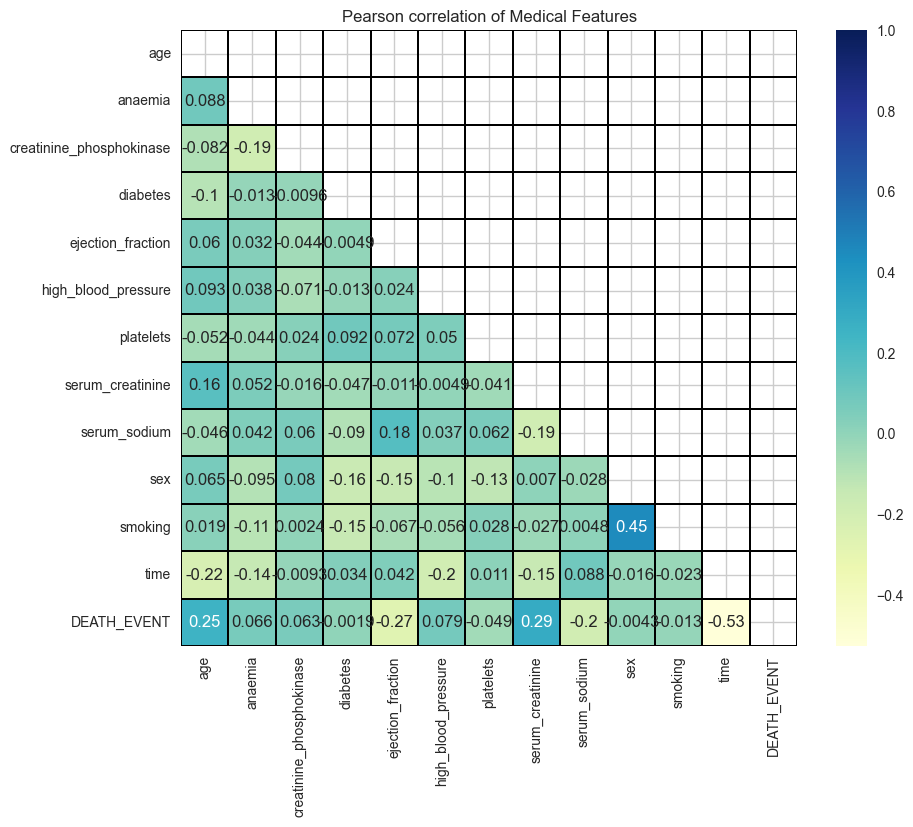

In [9]:
f, ax = plt.subplots(figsize=(10, 8))
plt.title('Pearson correlation of Medical Features')

corr = df.astype(float).corr()
matrix = np.triu(corr)

sns.heatmap(corr, linewidths=0.25, vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True, mask=matrix)

Nous remarquons qu'il y a très peu de correlation entre les différentes features de notre dataset, les seules que nous pouvons observer sont les corrélations entre la mort et l'**âge** du patient ainsi que la mort et la quantité de **créatinine sérique**.

Cela indique potentiellement que PCA va avoir du mal à garder de l'information en réduisant les dimensions.

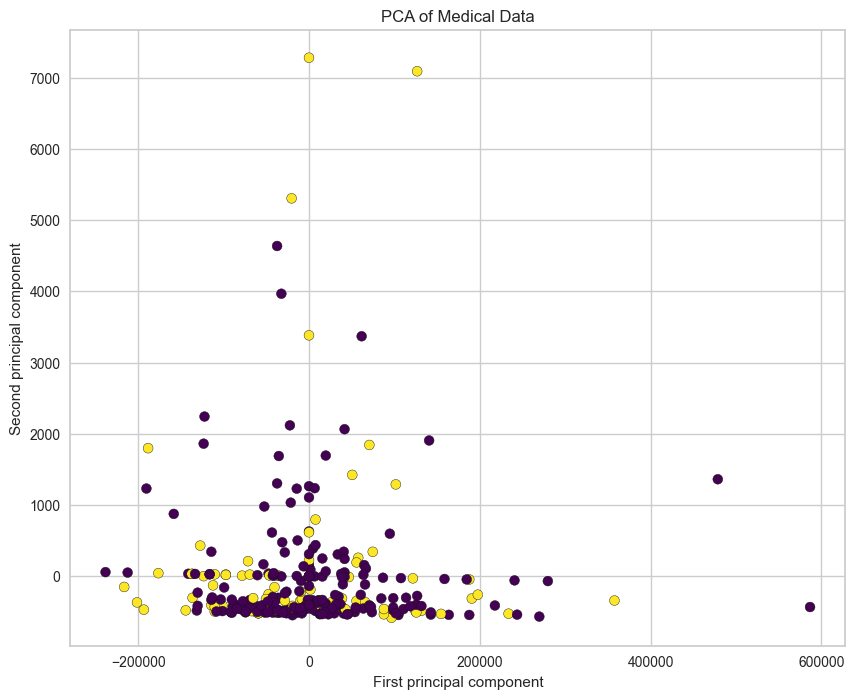

In [10]:
pca = PCA(n_components=12)
pca_components = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=y, edgecolor='k', s=50, cmap='viridis')
plt.title('PCA of Medical Data')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

0n remarque les échelles ne sont pas adaptés entre les 2 composants principaux, c'est pourquoi on va scaler la donnée.

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

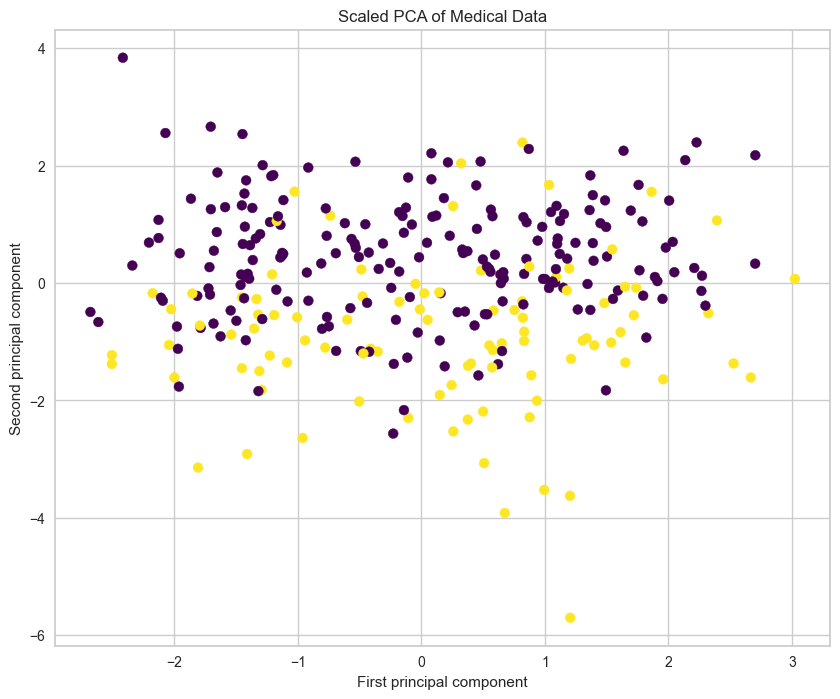

In [12]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=y, s=50, cmap='viridis')
plt.title('Scaled PCA of Medical Data')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()

Ici, bien que le scaling nous a permis de mieux représenter les 2 composants principaux, on remarque qu'il n'y a pas de distinction très remarquable entre les individus ayant survécu (violet) à leur insuffisance cardiaque et ceux décédés (jaune).

## Recherche du nombre de clusters optimaux <a id="clusters"></a>
---
### Silhouette Score & Calinksi-Harabasz score <a id="scores"></a>

In [13]:
for nb_clusters in range(2, 12):
    labels = KMeans(n_clusters=nb_clusters, random_state=69).fit_predict(X_scaled)

    s_score = silhouette_score(X_scaled, labels, metric='euclidean')
    ch_score = calinski_harabasz_score(X_scaled, labels)

    print(f"{nb_clusters} clusters - Silhouette score : {s_score} ; Calinski-Harabasz score : {ch_score}")

2 clusters - Silhouette score : 0.1178512561512019 ; Calinski-Harabasz score : 35.89467153213675
3 clusters - Silhouette score : 0.09637060159627105 ; Calinski-Harabasz score : 28.806050675122645
4 clusters - Silhouette score : 0.10118232322383694 ; Calinski-Harabasz score : 26.429984514361962
5 clusters - Silhouette score : 0.09467367033862219 ; Calinski-Harabasz score : 22.86449537779337
6 clusters - Silhouette score : 0.08665379513077115 ; Calinski-Harabasz score : 20.73003011091283
7 clusters - Silhouette score : 0.09728909103673418 ; Calinski-Harabasz score : 21.89501575815713
8 clusters - Silhouette score : 0.09056482535968492 ; Calinski-Harabasz score : 20.410455903461614
9 clusters - Silhouette score : 0.09902594667407394 ; Calinski-Harabasz score : 21.925964960221947
10 clusters - Silhouette score : 0.10088254166265363 ; Calinski-Harabasz score : 20.44565572296209
11 clusters - Silhouette score : 0.10069900924588046 ; Calinski-Harabasz score : 19.87192305403


### Elbow Method <a id="elbow"></a>

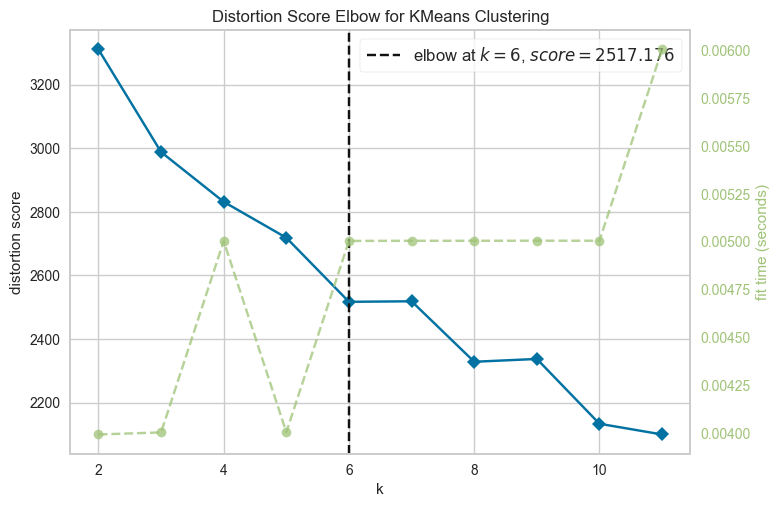

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 12))
visualizer.fit(X_scaled)
visualizer.show()

Les résultats obtenus avec ces trois méthodes sont assez intéressants. La méthode **Elbow** semble indiquer un résultat optimal avec 6 clusters, tandis que le **silhouette score** et le **Calinski-Harabasz score** sont au plus bas à 6 clusters, alors qu'un score élevé est censé traduire des clusters bien définis. Cela s'explique par le fait que ce sont des heuristiques, donc le résultat peut beaucoup varier entre les différentes méthodes.

## Entraînement et évaluation de modèles <a id="models"></a>
---

### Modèle de base <a id="basic"></a> 

In [15]:
for nb_clusters in range(2, 10):
    labels = KMeans(n_clusters=nb_clusters, random_state=69).fit_predict(X_scaled)

    ars = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels)

    print(f"{nb_clusters} clusters - Adjusted Rand Score : {ars} ; Normalized Mutual Info Score : {nmi}")

2 clusters - Adjusted Rand Score : -0.003679958186572638 ; Normalized Mutual Info Score : 2.1945886462775283e-05
3 clusters - Adjusted Rand Score : 0.045349551565627186 ; Normalized Mutual Info Score : 0.04930996681682932
4 clusters - Adjusted Rand Score : 0.05566417472783407 ; Normalized Mutual Info Score : 0.065081614166387
5 clusters - Adjusted Rand Score : 0.023090178813317062 ; Normalized Mutual Info Score : 0.038223385802031606
6 clusters - Adjusted Rand Score : 0.03537772718095154 ; Normalized Mutual Info Score : 0.05056172534032877
7 clusters - Adjusted Rand Score : 0.028039199244492247 ; Normalized Mutual Info Score : 0.038670342442108124
8 clusters - Adjusted Rand Score : 0.02323053234072828 ; Normalized Mutual Info Score : 0.049460449325475914
9 clusters - Adjusted Rand Score : 0.02923566051653692 ; Normalized Mutual Info Score : 0.0695744867342796


D'après l'**ARI**, qui indique la correspondance entre les clusters et les vrais labels et la **NMI**, qui indique la correlation entre les clusters et les vrais labels, avoir 4 clusters semble donner les meilleurs résultats, bien que ces derniers ne semblent pas très concluants.

Il est intéressant de voir que 4 semblait être un bon nombre de clusters d'après le **Silhouette score**, mais le *Calinski-Harabasz score* ou la méthode *Elbow* ne laissaient pas penser cela.

Pour observer nos résultats, on peut utiliser **PCA** pour réduire les 12 dimensions de nos features à 2 dimensions. 

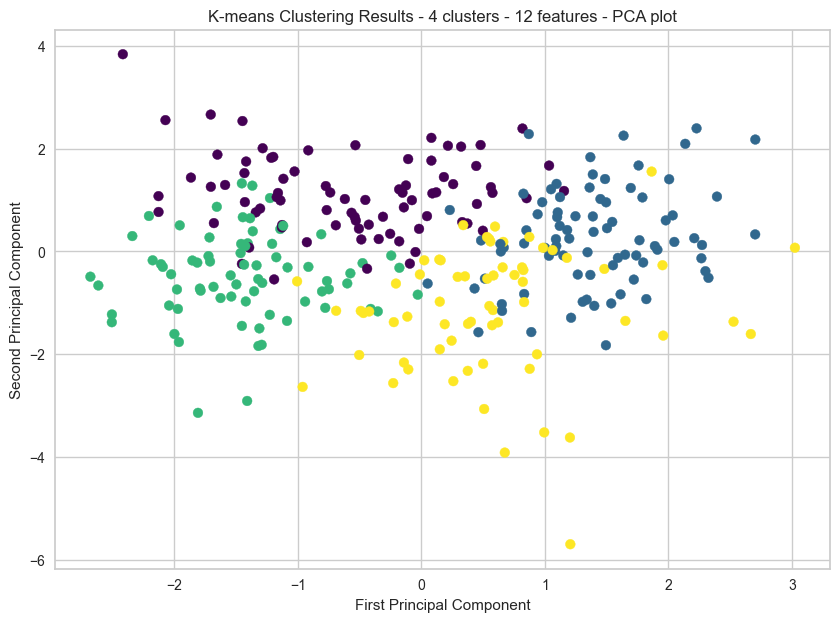

In [16]:
labels = KMeans(n_clusters=4, random_state=69).fit_predict(X_scaled)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering Results - 4 clusters - 12 features - PCA plot')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

### Améliorations <a id="improvements"></a>

Pour améliorer nos résultats, nous pouvons dans un premier temps utiliser les **n** composants principales de PCA comme **X**.

In [17]:
for nb_components in range(2, 10):
    print(f"\n----- {nb_components} PCA components -----\n")

    pca = PCA(n_components=nb_components)
    pca_components = pca.fit_transform(X_scaled)

    for nb_clusters in range(2, 10):
        labels = KMeans(n_clusters=nb_clusters, random_state=69).fit_predict(pca_components)

        ars = adjusted_rand_score(y, labels)
        nmi = normalized_mutual_info_score(y, labels)

        print(f'{nb_clusters} clusters - Adjusted Rand Score : {ars} ; Normalized Mutual Info Score : {nmi}')


----- 2 PCA components -----

2 clusters - Adjusted Rand Score : 0.0077334852417867 ; Normalized Mutual Info Score : 0.011456094042349558
3 clusters - Adjusted Rand Score : 0.12022518676225034 ; Normalized Mutual Info Score : 0.10884440060847343
4 clusters - Adjusted Rand Score : 0.09127712741859634 ; Normalized Mutual Info Score : 0.10813785124174137
5 clusters - Adjusted Rand Score : 0.04967044717241943 ; Normalized Mutual Info Score : 0.09290655276525388
6 clusters - Adjusted Rand Score : 0.04949574526603981 ; Normalized Mutual Info Score : 0.08839069802327008
7 clusters - Adjusted Rand Score : 0.04434992450430644 ; Normalized Mutual Info Score : 0.07457101841129567
8 clusters - Adjusted Rand Score : 0.0362730816483949 ; Normalized Mutual Info Score : 0.08102270450817839
9 clusters - Adjusted Rand Score : 0.037159187880720895 ; Normalized Mutual Info Score : 0.08483987449759739

----- 3 PCA components -----

2 clusters - Adjusted Rand Score : 0.004064357422212217 ; Normalized Mutua

On remarque qu'en gardant les 3 composantes principales de PCA et avec 3 clusters, on arrive à obtenir un **ARS** de **0.14** et un **NMI** de **0.13**, ce qui plus du double de ce qu'on avait avant.

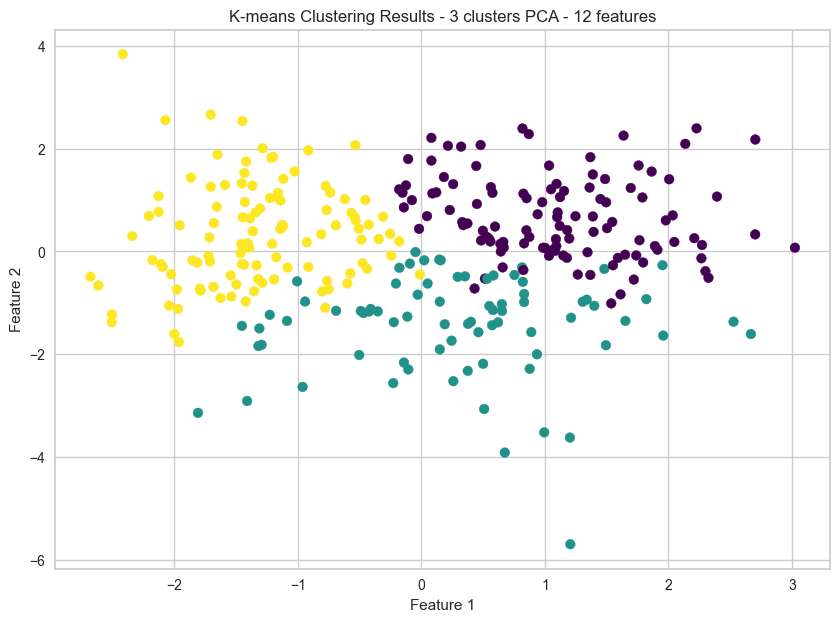

In [18]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)

labels = KMeans(n_clusters=3, random_state=69).fit_predict(pca_components)

plt.figure(figsize=(10, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering Results - 3 clusters PCA - 12 features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Il nous reste maintenant à voir si en enlevant certaines features inutiles du dataset on arrive à avoir de meilleurs résultats que ceux précédents.

In [19]:
df[df["DEATH_EVENT"] == 0].std()

age                            10.637890
anaemia                         0.492840
creatinine_phosphokinase      753.799572
diabetes                        0.494569
ejection_fraction              10.859963
high_blood_pressure             0.469579
platelets                   97531.202283
serum_creatinine                0.654083
serum_sodium                    3.982923
sex                             0.478071
smoking                         0.469579
time                           67.742872
DEATH_EVENT                     0.000000
dtype: float64

In [20]:
df[df["DEATH_EVENT"] == 1].std()

age                            13.214556
anaemia                         0.502188
creatinine_phosphokinase     1316.580640
diabetes                        0.495595
ejection_fraction              12.525303
high_blood_pressure             0.493710
platelets                   98525.682856
serum_creatinine                1.468562
serum_sodium                    5.001579
sex                             0.480771
smoking                         0.465946
time                           62.378281
DEATH_EVENT                     0.000000
dtype: float64

Nous remarquons un changement de variance très faible entre les 2 états finaux pour les features suivantes : **anaemia**, **diabetes**, **high_blood_pressure**, **platelets**, **sex** et **smoking**.

Nous allons donc les supprimer de nos données et observer de nouveaux les résultats, en utilisant directement PCA.

In [21]:
df_clean = df.drop(columns=["anaemia", "diabetes", "high_blood_pressure", "platelets", "sex", "smoking"])

In [22]:
X_clean = df_clean.drop(columns=["DEATH_EVENT"])

In [23]:
scaler = StandardScaler()
X_clean_scaled = scaler.fit_transform(X_clean)

In [24]:
for nb_components in range(2, 7):
    print(f"\n----- {nb_components} PCA components -----\n")

    pca = PCA(n_components=nb_components)
    pca_components = pca.fit_transform(X_clean_scaled)

    for nb_clusters in range(2, 10):
        labels = KMeans(n_clusters=nb_clusters, random_state=69).fit_predict(pca_components)

        ars = adjusted_rand_score(y, labels)
        nmi = normalized_mutual_info_score(y, labels)

        print(f'{nb_clusters} clusters - Adjusted Rand Score : {ars} ; Normalized Mutual Info Score : {nmi}')


----- 2 PCA components -----

2 clusters - Adjusted Rand Score : 0.37697545357722745 ; Normalized Mutual Info Score : 0.25237342121531786
3 clusters - Adjusted Rand Score : 0.17973342065807832 ; Normalized Mutual Info Score : 0.13719991425263156
4 clusters - Adjusted Rand Score : 0.09990969541086117 ; Normalized Mutual Info Score : 0.11847498294796716
5 clusters - Adjusted Rand Score : 0.10678757662345756 ; Normalized Mutual Info Score : 0.13997244319036545
6 clusters - Adjusted Rand Score : 0.09069572602547872 ; Normalized Mutual Info Score : 0.12029411278920037
7 clusters - Adjusted Rand Score : 0.08366110474186945 ; Normalized Mutual Info Score : 0.1251192093430095
8 clusters - Adjusted Rand Score : 0.09052133337574121 ; Normalized Mutual Info Score : 0.1256485495960055
9 clusters - Adjusted Rand Score : 0.0687225845485487 ; Normalized Mutual Info Score : 0.12956846719964285

----- 3 PCA components -----

2 clusters - Adjusted Rand Score : 0.37697545357722745 ; Normalized Mutual In

Nous obtenons ainsi un **ARS** de 0.38 et un **NMI** de 0.25 en gardant les 2 composants principaux de PCA et avec 2 clusters, mais surtout en ayant enlevé la moitié des features !

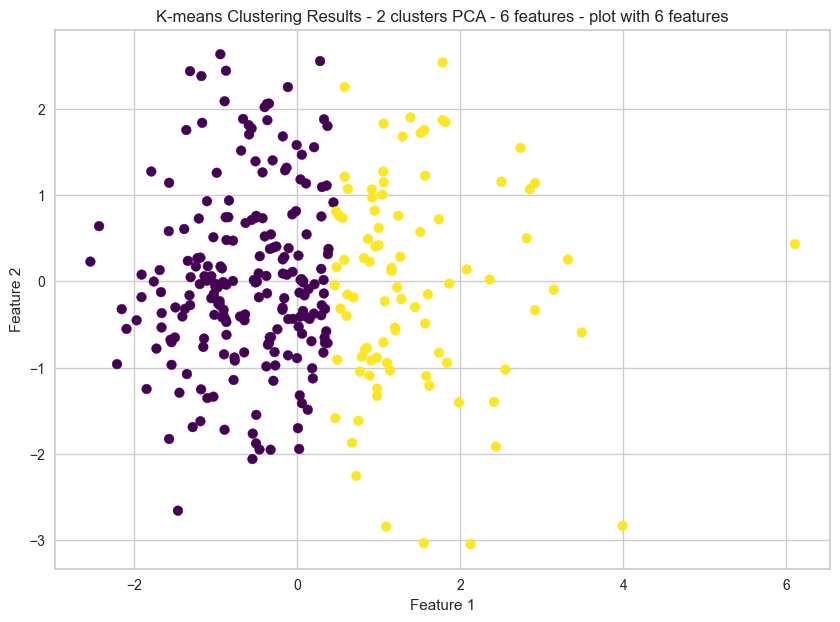

In [25]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_clean_scaled)

labels = KMeans(n_clusters=2, random_state=69).fit_predict(pca_components)

plt.figure(figsize=(10, 7))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering Results - 2 clusters PCA - 6 features - plot with 6 features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Le fait d'avoir enlevé la moitié des features change la position des points dans l'espace des 2 dimensions PCA, nous verrons donc dans la figure suivante le résultat avec les features initiales, qui commence à ressembler à la figure avec les vrais labels. 

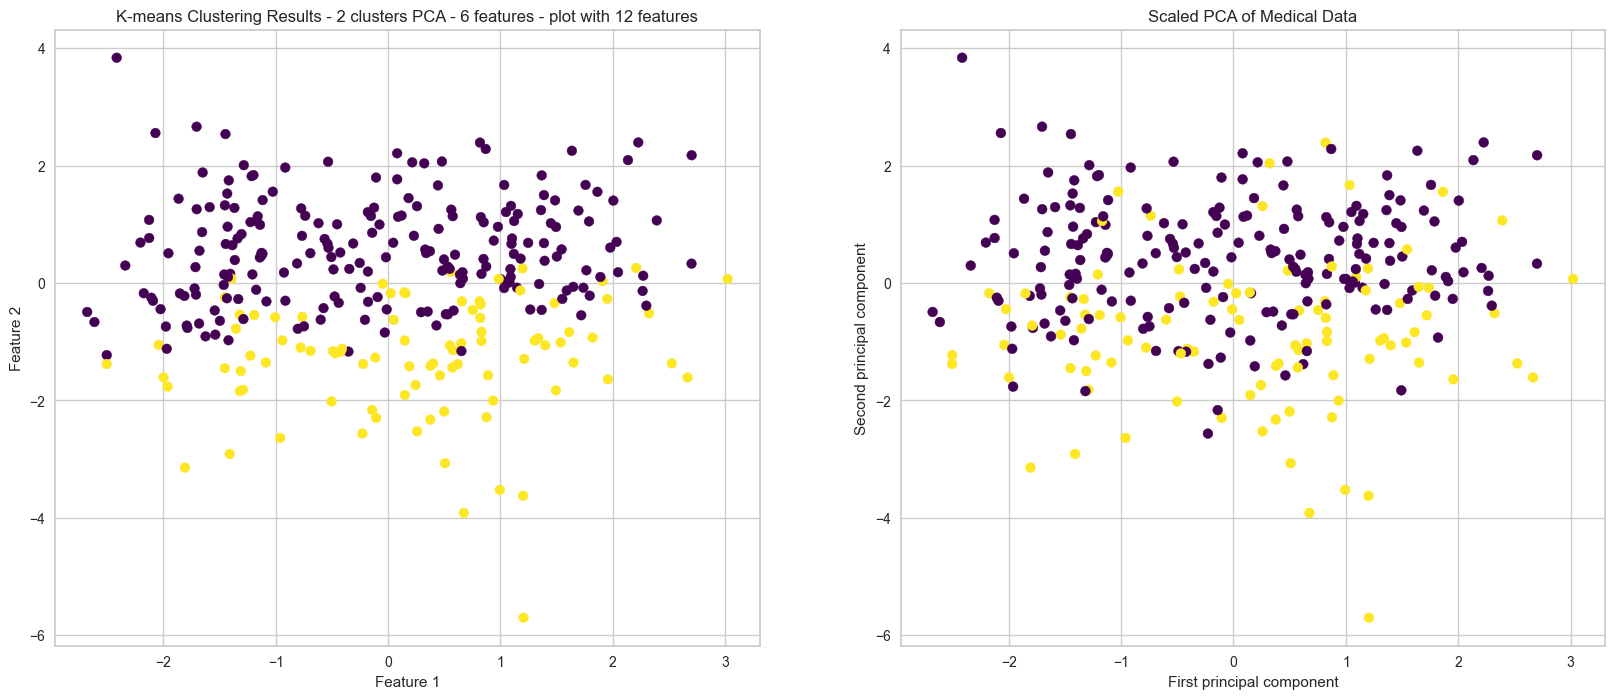

In [26]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis')
plt.title('K-means Clustering Results - 2 clusters PCA - 6 features - plot with 12 features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=y, s=50, cmap='viridis')
plt.title('Scaled PCA of Medical Data')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

plt.show()

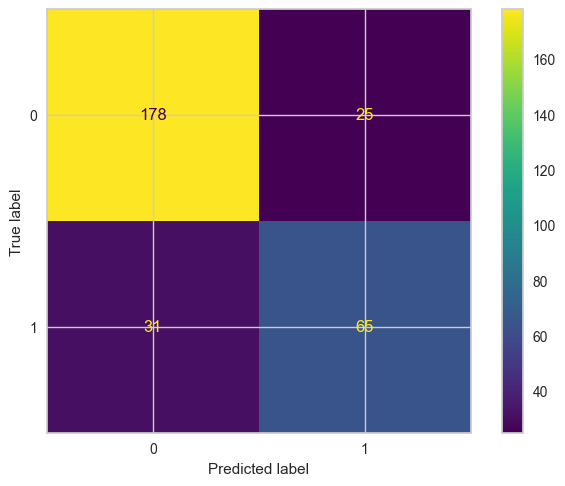

In [31]:
ConfusionMatrixDisplay.from_predictions(y, labels)